In [16]:
import matplotlib.pyplot as plt
import numpy as np
import mcu
import data
from importlib import reload

In [17]:
reload(data)
reload(mcu)

np.random.seed(57179179)
control_vars = data.get_control_vars(data.get_p())
response_matrix = data.generate_array_of_swiss_rolls(control_vars)
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = mcu.prepare_data(control_vars, response_matrix)
q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges)

/home/glebka/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


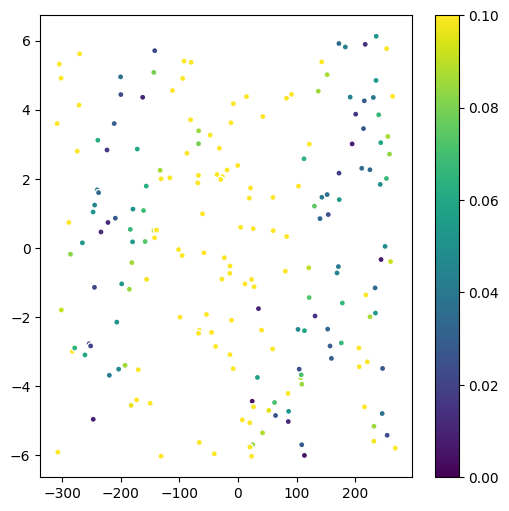

0.08674988452378629


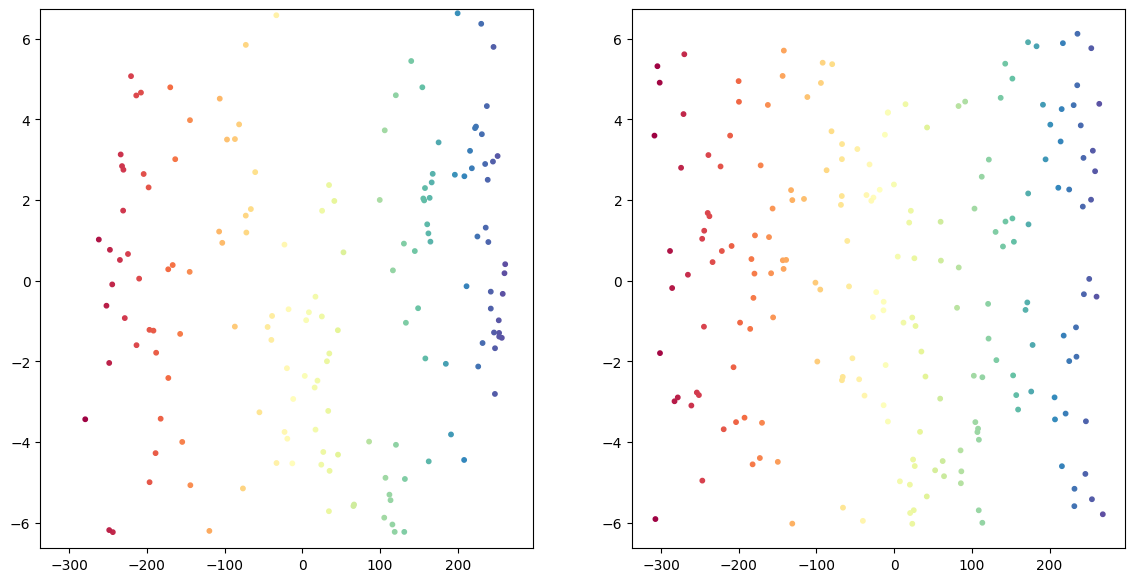

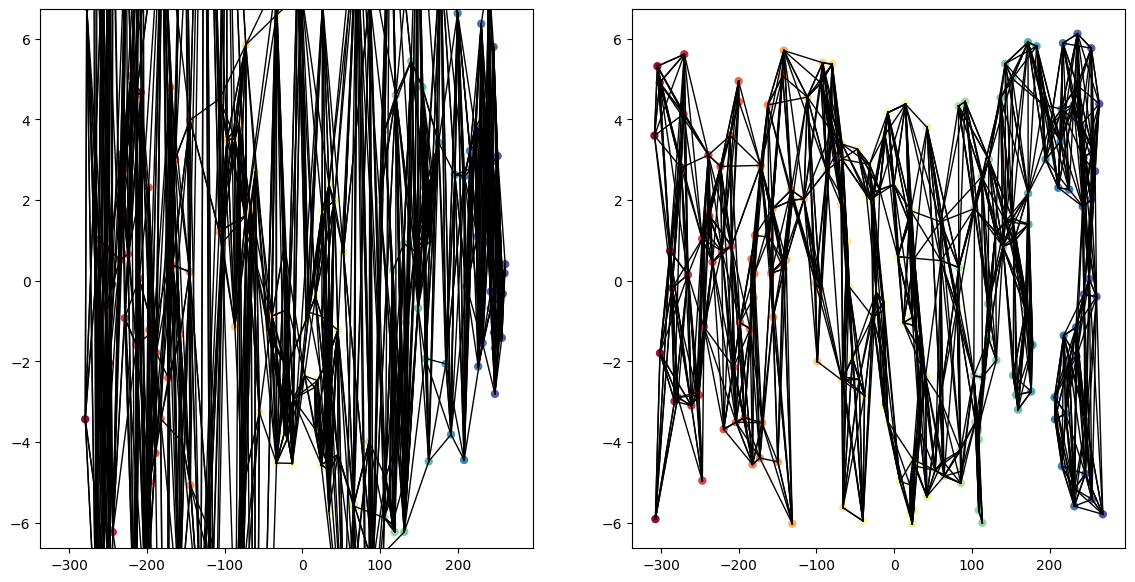

In [18]:
reload(mcu)
m_ = control_vars.shape[1]
# m_ = get_optimal_dimensionality(s)
ld_embedding = mcu.reduce_dimensions(q, m_)
regression_matrix = mcu.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)

rre = mcu.compute_rre(ld_embedding, reconstructed_y)
mcu.plot_rre_heatmap(rre, reconstructed_y)
print(np.median(rre))
mcu.plot_two_embeddings(ld_embedding, reconstructed_y)
mcu.plot_two_embeddings_with_edges(ld_embedding, reconstructed_y, edges)
# print(np.sort(np.abs(mcu.diff_of_edges_lengths(ld_embedding, centered_y, edges)))[::-1])

In [19]:
reload(data)
reload(mcu)

n_of_tests = 100
test_control_vars = data.get_control_vars(data.get_p(), n_of_tests)
test_rolls = data.generate_array_of_swiss_rolls(test_control_vars, n_of_tests)
x_opts = []
for (roll, control_var) in zip(test_rolls, test_control_vars):
    x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means, y_scaler)
    x_opt = x_opt * x_stds + x_means
    x_opts.append(x_opt)
    print("-----------")
    print(f"x_opt  = {x_opt}, x_err = {x_err}")
    print(f"x_real = {control_var}")

x_ops = np.array(x_opts)
test_control_vars = np.array(test_control_vars)

-----------
x_opt  = [2.90101816 6.01568908], x_err = 1.6961818733086019e-12
x_real = [4.0579897  6.01539158]
-----------
x_opt  = [8.66737346 2.68007653], x_err = 2.5039541274166784e-12
x_real = [5.7646279  2.65983143]
-----------
x_opt  = [7.68319086 8.20996714], x_err = 2.8396881237004832e-12
x_real = [5.70154302 7.9351466 ]
-----------
x_opt  = [3.21327053 5.48145655], x_err = 2.280970576677865e-12
x_real = [9.82266305 5.74785166]
-----------
x_opt  = [7.23042731 7.30942149], x_err = 9.953457123491215e-13
x_real = [3.48506338 6.95104633]
-----------
x_opt  = [4.738395   3.97388018], x_err = 1.357597114733938e-12
x_real = [4.478867   4.09941895]
-----------
x_opt  = [4.41566011 7.03812456], x_err = 2.4506360351261236e-12
x_real = [8.13589995 6.72988027]
-----------
x_opt  = [3.98135542 3.46922901], x_err = 1.2503086084070077e-12
x_real = [4.63310108 3.89464668]
-----------
x_opt  = [6.18344361 6.3622417 ], x_err = 2.1783851126237754e-12
x_real = [3.99592666 6.03678615]
-----------
x

[1.15697157 2.90281616 2.00061353 6.61475894 3.76247042 0.28829632
 3.73298794 0.77830109 2.21159484 5.07144943 4.16216584 1.46824627
 0.94567616 4.35431767 6.7033156  3.92989748 3.68512231 4.1127475
 0.142171   6.47804518 1.19465532 0.74247401 0.53167318 3.56142386
 3.23678803 1.98281907 0.48050363 3.19793429 0.70238671 5.34129763
 5.76892828 0.58556252 5.20999039 3.95399946 1.21755511 2.34130091
 3.91908899 2.13797808 0.57400885 0.96183407 4.6235393  4.04331624
 2.87143327 5.27889746 2.72008659 1.00674367 0.80753199 5.87663158
 1.69985922 4.54860148 6.54311932 3.66810608 1.66090196 1.23172544
 1.42551637 3.16846627 1.0363819  3.90443445 5.147142   4.46365835
 1.25742436 4.58341067 3.67499853 4.23632276 4.25331943 1.83408076
 1.27842249 4.97343061 0.27067804 1.78760624 2.58348055 4.57304585
 4.13613897 0.66078342 7.72613036 4.22500387 0.60944647 5.21384051
 2.56950654 0.34839063 6.52120994 2.06266647 3.91317268 0.86868821
 2.34027476 4.68039075 5.2239429  1.58595878 0.58385814 6.16939

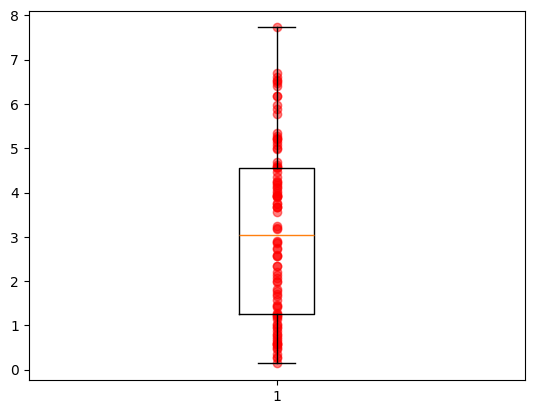

In [20]:
errors = np.linalg.norm(x_opts - test_control_vars, axis = 1)
plt.boxplot(errors)
plt.scatter(np.ones_like(errors), errors, alpha=0.5, color='red')
print(errors)
print(f"Median of errors = {np.median(errors)}")